# Example Code for Using the Continuous Trigger Code
------------------------
Import the need packages to run the test notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import qetpy as qp
from rqpy import io, process
from time import time

%matplotlib inline

Let's get a list of the included data that we will study. We'll use two Stanford DAQ .mat files.

In [2]:
fpath = sorted(glob("test_data_*.mat"))

We'll load one of the files, in order to take a look at the properties. Note the `convtoamps` optional argument. This is by default set to 1024, which is the current value that the Stanford data should be divided by in order to convert to Amps.

In [3]:
traces, times, fs, ttl = io.loadstanfordfile(fpath[0])

Now, let's  first use the `acquire_randoms` function to find `n` random traces of the specified length `l`. These random traces are taken from the two datasets such that they can be anywhere in each file, but must not overlap with any other random trace. 

This function automatically saves the data to `.npz` files. This is because, in practice, the user may be running the trigger on large datasets. We do not want to store all of the traces in memory at the same time, so we save the events to files in dumps. We should input what we want to save the files as and where.

In [4]:
process.acquire_randoms?

Signature: process.acquire_randoms(filelist, n, l, datashape=None, iotype='stanford', savepath=None, savename=None, dumpnum=1, maxevts=1000, convtoamps=0.0009765625)
Docstring:
Function for acquiring random traces from a list of files and saving the results
to a .npz file for later processing.

Parameters
----------
filelist : list of strings
    List of files to be opened to take random sections from (should be full paths)
n : int
    Number of sections to choose
l : int
    Length in bins of sections
datashape : tuple, NoneType, optional
    The shape of the data in each file. If inputted, this should be a tuple that is 
    (# of traces in a dataset, # of bins in each trace). If left as None, then the first file 
    in filelist is opened, and the shape of the data in it is used.
iotype : string, optional
    Type of file to open, uses a different IO function. Default is "stanford".
        "stanford" : Use qetpy.io.loadstanfordfile to open the files
savepath : NoneType, str, option

In [5]:
n, l = 100, 125000
savepath = ""
savename = "test_data_randoms"

start = time()
process.acquire_randoms(
    fpath,
    n,
    l,
    datashape=traces.shape[::2],
    savepath=savepath,
    savename=savename,
    dumpnum=1,
    maxevts=1000,
    convtoamps=1,
)
print(time()-start)

5.201319694519043


Now, let's load the saved dataset(s) to see how the randoms data was saved. Since we save as a `.npz` file, we use `np.load` to open the file(s).

In [6]:
with np.load(f"test_data_randoms_0001.npz") as data:
    print(list(data.keys()))
    randomstimes = data["randomstimes"]
    randomstraces = data["traces"]

['pulsetimes', 'pulseamps', 'trigtimes', 'trigamps', 'randomstimes', 'traces', 'trigtypes', 'truthamps', 'truthtdelay']


Note that the only data that was saved were the times of the randoms and the traces. If we looked at the other fields, they would simply be empty.

With the randoms data loaded, we can sum the two channels and use `autocuts` to quickly choose the good traces. We can then estimate the PSD.

In [7]:
pt = randomstraces.sum(axis=1) # triggering on sum of all channels
cut = qp.autocuts(pt, fs=fs)
f, psd = qp.calc_psd(pt[cut], fs=fs, folded_over=False)

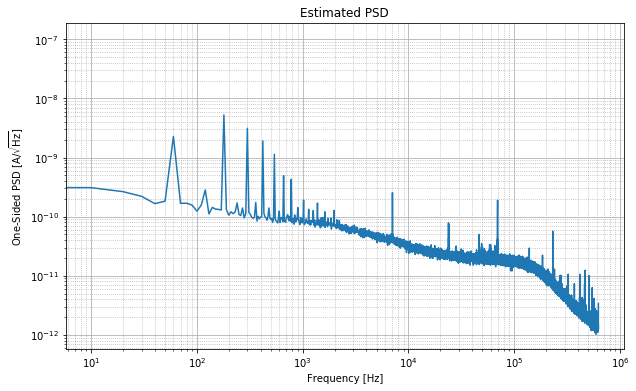

In [8]:
f_fold, psd_fold = qp.foldpsd(psd, fs=fs)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(f_fold, np.sqrt(psd_fold))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"One-Sided PSD [A/$\sqrt{\mathrm{Hz}}$]");
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.set_title("Estimated PSD");

Now, we want to start detecting events via the pulse/ttl triggers, which will do via the `acquire_pulses` function. We can look at the documentation to see what the inputs/outputs will be.

In [9]:
process.acquire_pulses?

Signature: process.acquire_pulses(filelist, template, noisepsd, tracelength, thresh, nchan=2, chan_to_trigger='all', trigtemplate=None, trigthresh=None, positivepulses=True, iotype='stanford', savepath=None, savename=None, dumpnum=1, maxevts=1000, lgcoverlap=True, convtoamps=0.0009765625)
Docstring:
Function for running the continuous trigger on many different files and saving the events 
to .npz files for later processing.

Parameters
----------
filelist : list of strings
    List of files to be opened to take random sections from (should be full paths)
template : ndarray
    The pulse template to be used when creating the optimum filter (assumed to be normalized)
noisepsd : ndarray
    The two-sided power spectral density in units of A^2/Hz
tracelength : int
    The desired trace length (in bins) to be saved when triggering on events.
thresh : float
    The number of standard deviations of the energy resolution to use as the threshold for which events
    will be detected as a pulse.

Let's make a dummy pulse template that is close to what we've historically seen. A more detailed pulse template analysis would need to be done in practice, but we can do this for a quick test.

In [10]:
tracelength = 125000
# Dummy pulse template
nbin = len(psd)
ind_trigger = round(nbin / 2)
tt = 1.0/fs *(np.arange(1, nbin+1) - ind_trigger)
lgc_b0 = tt < 0.0

# pulse shape
tau_rise = 20.0e-6
tau_fall = 80.0e-6
testtemplate = np.exp(-tt / tau_fall) - np.exp(-tt / tau_rise)
testtemplate[lgc_b0] = 0.0
testtemplate = testtemplate / max(testtemplate)

Since we have a TTL channel in this data, we want to also set a TTL template, so that we can detect the TTL triggers. These look like short square wave pulses. Note that if the TTL pulses are in the negative direction (such is in this case), then the user should simply multiply this TTL template by -1.

In [11]:
nbinttl = 64
ttltime = 8e-6 # length of ttl pulse in seconds
ttllen = int(ttltime * fs)
ind_trigger = ttllen//2

ttltemplate = np.zeros(nbinttl)
ttltemplate[ind_trigger:ind_trigger + ttllen] = -1

Let's set the thresholds. The pulse threshold is set to 10$\sigma$ of the energy resolution, in order to ensure we get pulses. The TTL threshold is set to 0.2, which was done by hand. This was set to a value that is lower than the true amplitude of the TTL pulse (which, in this case, is 1.0), such that the TTL pulses will be detected as when the estimated TTL amplitude is greater than the set threshold. Note that the TTL threshold can be low, which is because the TTL channel has nearly no noise.

In [12]:
thresh = 10
ttlthresh = 0.2

We can now run the continuous trigger on the two data files using `acquire_pulses`, setting the path and filename to use when saving the data.

In [13]:
savepath = ""
savename = "test_data_pulses"

start = time()
process.acquire_pulses(
    fpath,
    testtemplate,
    psd,
    tracelength,
    thresh,
    positivepulses=False,
    trigtemplate=ttltemplate,
    trigthresh=ttlthresh,
    iotype="stanford",
    savepath=savepath,
    savename=savename,
    chan_to_trigger='all', # trigger on sum of all channels, can be changed to specify channels
    dumpnum=1,
    maxevts=1000,
    convtoamps=1,
)
print(time()-start)

13.069699048995972


Now that we've ran the continuous trigger on the data, let's load the first dump to see what the events look like.

In [14]:
with np.load("test_data_pulses_0001.npz") as data:
    print(list(data.keys()))
    trigtimes = data["trigtimes"]
    trigamps = data["trigamps"]
    pulsetimes = data["pulsetimes"]
    pulseamps = data["pulseamps"]
    trigtypes = data["trigtypes"]
    traces = data["traces"]

['pulsetimes', 'pulseamps', 'trigtimes', 'trigamps', 'randomstimes', 'traces', 'trigtypes', 'truthamps', 'truthtdelay']


Let's look at the first detected event to see a triggered event.

In [15]:
ii = 0
print(trigtypes[ii])

[False  True  True]


Note that the trigger types array for this event says that both the pulse and TTL were triggered. The code has been written such that the traces are centered on the TTL trigger (i.e. the TTL is the primary trigger). However, we save the time and amplitude of the pulse as well. Thus, to compare the pulse and the template, we need to take this time difference into account.

Let's look at the result, zoomed into the center of the trace to see the pulse.

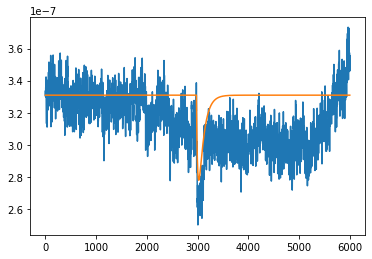

In [16]:
plt.plot(
    traces[ii].sum(axis=0)[traces.shape[-1]//2 - 3000:traces.shape[-1]//2 + 3000],
)

temp = testtemplate * pulseamps[ii] + traces[ii].sum(axis=0).mean()
if trigtimes[ii]!=0:
    temp = np.roll(
        temp,
        int((pulsetimes[ii] - trigtimes[ii]) * fs),
    )

plt.plot(
    temp[traces.shape[-1]//2 - 3000:traces.shape[-1]//2 + 3000],
);

And we see a pulse!